In [1]:
# Data Manipulation
# ======================================================
import pandas as pd 
import numpy as np
from os import path
import configparser
from epiweeks import Week
from datetime import date, datetime
from calendar import month_name, month_abbr
from helper_functions import *
import math

# Statistics
# ======================================================

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.Sarimax import Sarimax
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_sarimax import backtesting_sarimax, grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.ForecasterBaseline import ForecasterEquivalentDate


# Reading Secrets
# ======================================================
cfg = configparser.ConfigParser()
cfg.read('secrets.ini')
ROOT_PATH = path.abspath(cfg.get('default','root'))
DATA_PATH = path.join(ROOT_PATH, 'src/data')

# Warnings Config
# ======================================================
import warnings
warnings.filterwarnings('ignore')

c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading & Manipulating Dataset
# ======================================================

df = pd.read_csv(path.join(DATA_PATH, 'raw_dataset.csv'))

df['epiweek'] = df['epiweek']\
                .map(lambda x: Week.fromstring(str(x)))

df['weekstart'] = pd.to_datetime(
                                df['epiweek']\
                                .map(lambda x: Week.startdate(x))
                                )

df.set_index('weekstart', inplace=True)

df['epiweek'] = df['epiweek']\
                .map(lambda x: int(str(x)[4:]))

col_ordered = (
                'cases','visits','GS_cold', 
                'GS_cough', 'GS_fever', 'GS_flu', 
                'AWND', 'PRCP', 'SNOW', 
                'TMAX', 'TMIN', 'TAVG',
                'Overall AQI Value',
                'CO', 'Ozone', 'PM10', 
                'PM25', 'Days Good',
                'Days Moderate', 'Days Unhealthy'
                )

means = df[list(col_ordered)].groupby(df.index.month).mean()
means.index.name = 'month'
df['month'] = df.index.month

df = df.reset_index().set_index(['weekstart','month'])

df['TAVG'] = df[['TAVG']].fillna(
                            pd.DataFrame(
                            (df['TMAX'] + df['TMIN']) / 2)\
                            .rename(columns={0:'TAVG'})
                                )

df[list(col_ordered)] = df[list(col_ordered)].fillna(means)

# One-hot encoding 'Main Pollutant'
df['Main Pollutant'] = df['Main Pollutant'].astype('category')
df = pd.get_dummies(df)\
    .drop(columns=["Main Pollutant_['Ozone' 'PM2.5']"])

df = df.astype({col: np.float32 for col in df.select_dtypes("number").columns})

# Cyclical encoding 'epiweek' to capture the cyclic nature
# i.e. week_1, week_2, ... week_52, week_1 ...
# cyclical_encoding() returns the sine and the cosine transformation of the input variable

epiweek_encoded = cyclical_encoding(df['epiweek'].apply(lambda x: x-1), cycle_length=52)


df = pd.concat([df, epiweek_encoded], axis=1)
df = df.reset_index()\
    .set_index('weekstart')\
    .drop(columns=['month'])\
    .resample('W').first()\
    .fillna(method='ffill')

variables = ['GS_cold', 'GS_cough', 'GS_fever', 'GS_flu', 
            'AWND', 'PRCP','SNOW', 'TAVG','TMAX', 'TMIN',
            'Overall AQI Value', 
            'CO', 'Ozone', 'PM10', 'PM25', 'Days Moderate', 
            'Days Unhealthy', 'visits','Main Pollutant_CO', 
            'Main Pollutant_NO2', 'Main Pollutant_PM2.5']

for v in variables:
    for i in range(1,4):
        df[f'{v}_L{i}'] = df[v].shift(i)

df = df.dropna()

end_train, end_validation, df_train, df_val, df_test = train_test_validate_split(
                                                        df, end_train = date(2015,12,31), 
                                                        end_validation = date(2017,12,31)
                                                                                )

Dates train      : 2005-01-16 00:00:00 --- 2015-12-27 00:00:00  (n=572)
Dates validacion : 2016-01-03 00:00:00 --- 2017-12-31 00:00:00  (n=105)
Dates test       : 2017-12-31 00:00:00 --- 2019-12-29 00:00:00  (n=105)


In [29]:
forecaster1 = ForecasterAutoreg(
    regressor=ElasticNetCV(
        verbose=False,
        random_state=123,
        l1_ratio=.5,
        selection='cyclic'
    ),
    lags=[1,2,52],
    transformer_y=FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate=True),
    transformer_exog=StandardScaler(),

)
forecaster1.fit(y=df_train['cases'],exog=df_train.drop(columns=['cases']))

met, preds = backtesting_forecaster(
    forecaster = forecaster1,
    y = df['cases'][:end_validation],
    exog = df.drop(columns=['cases'])[:end_validation],
    initial_train_size = len(df_train),
    steps = 2,
    metric = 'mean_absolute_error',
    refit = False,

)


100%|██████████| 53/53 [00:00<00:00, 196.45it/s]


In [30]:
print(met)

225.2800267439313


In [31]:
lags_grid = [[52],[1],[1,52],[1,2],[1,2,52],[1,2,3],[1,2,3,52]]
param_grid = {
    'l1_ratio':[.001, .05, 0.10, 0.50, 0.70],
    'selection':['cyclic','random']
}

results_grid = grid_search_forecaster(
    forecaster = forecaster1,
    y = df['cases'][:end_validation],
    exog = df.drop(columns=['cases'])[:end_validation],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=2,
    refit=False,
    metric='mean_squared_error',
    initial_train_size=len(df_train),
    fixed_train_size=True,
    return_best=True,
    verbose=False,
    show_progress=True
)

met, preds = backtesting_forecaster(
    forecaster = forecaster1,
    y = df['cases'][:end_validation],
    exog = df.drop(columns=['cases'])[:end_validation],
    initial_train_size = len(df_train),
    steps = 2,
    metric = 'mean_absolute_error',
    refit = False,

)
print(met)

Number of models compared: 70.


lags grid: 100%|██████████| 7/7 [00:27<00:00,  3.89s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1 52] 
  Parameters: {'l1_ratio': 0.1, 'selection': 'random'}
  Backtesting metric: 104937.6564688119



100%|██████████| 53/53 [00:00<00:00, 196.02it/s]

216.4302285042319


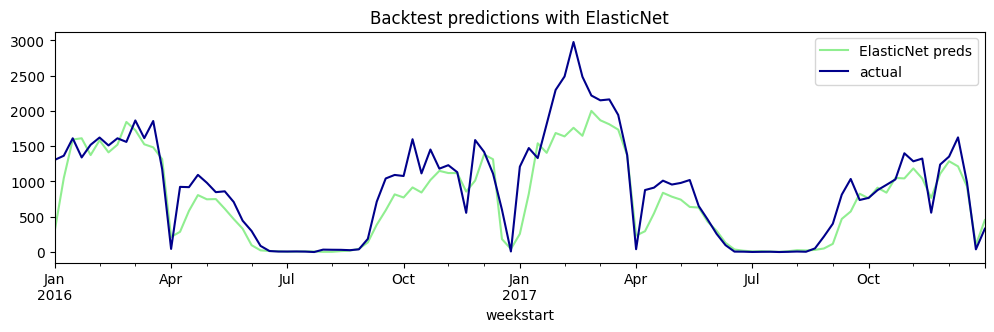

In [32]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3))
preds.rename(columns={'pred':'ElasticNet preds'}).plot(ax=ax, color='lightgreen')
df.loc[end_train:end_validation]['cases'].plot(ax=ax, label='actual', color='darkblue')
ax.set_title('Backtest predictions with ElasticNet')
ax.legend()

In [33]:
exog = pd.DataFrame(StandardScaler().fit_transform(df_train.drop(columns=['cases'])),columns=df_train.drop(columns=['cases']).columns,index=df_train.index)

In [35]:
exog['Main Pollutant_CO_L1'].unique()

array([-0.10295973,  9.71253486])

In [36]:
sarimaxmod2 = SARIMAX(endog=df_train['cases'].apply(np.log1p),exog=exog.drop(columns=['epiweek','Days Good']),order=(1, 1, 1),
        seasonal_order=(0, 1, 0, 52))


In [37]:
sarimaxres2 = sarimaxmod2.fit()
sarimaxres2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               cases   No. Observations:                  572
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -731.638
Date:                             Fri, 26 Jan 2024   AIC                           1643.275
Time:                                     19:52:25   BIC                           2025.947
Sample:                                 01-16-2005   HQIC                          1793.195
                                      - 12-27-2015                                         
Covariance Type:                               opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
GS_cold                    -0.1077      0.161     -0.670      0.503      -0.423       0.207
GS_cough                   -0.3015      0.342     -0.881      0.379      -0.972       0.370
GS_fever                   -0.1165      0.098     -1.189      0.235      -0.309       0.076
GS_flu                      0.0273      0.115      0.238      0.812      -0.198       0.252
AWND                        0.0015      0.080      0.019      0.985      -0.154       0.157
PRCP                        0.0808      0.046      1.760      0.078      -0.009       0.171
SNOW                       -0.1285      0.083     -1.557      0.119      -0.290       0.033
TAVG                       -0.1908      3.184     -0.060      0.952      -6.432       6.051
TMAX                        0.1372      1.806      0.076      0.939      -3.402       3.676
TMIN                       -0.3891      1.433     -0.271      0.786      -3.198       2.420
Overall AQI Value           0.0927      0.217      0.428      0.669      -0.332       0.517
CO                         -0.0292      0.090     -0.324      0.746      -0.206       0.147
Ozone                       0.0646      0.178      0.362      0.717      -0.285       0.414
PM10                       -0.1718      0.073     -2.363      0.018      -0.314      -0.029
PM25                        0.1619      0.103      1.571      0.116      -0.040       0.364
Days Moderate              -0.1185      0.091     -1.299      0.194      -0.297       0.060
Days Unhealthy             -0.0503      0.103     -0.489      0.625      -0.252       0.151
visits                      0.2443      0.094      2.601      0.009       0.060       0.428
Main Pollutant_CO          -0.0202      0.256     -0.079      0.937      -0.522       0.482
Main Pollutant_NO2          0.1828      0.505      0.362      0.718      -0.808       1.174
Main Pollutant_Ozone        0.2431      1.175      0.207      0.836      -2.060       2.546
Main Pollutant_PM2.5        0.3210      1.155      0.278      0.781      -1.943       2.585
epiweek_sin                -1.9164      1.432     -1.338      0.181      -4.723       0.890
epiweek_cos                -1.9474      1.707     -1.141      0.254      -5.293       1.398
GS_cold_L1                 -0.0675      0.177     -0.381      0.703      -0.415       0.280
GS_cold_L2                  0.0736      0.164      0.448      0.654      -0.248       0.396
GS_cold_L3                  0.1400      0.163      0.858      0.391      -0.180       0.460
GS_cough_L1                 0.3131      0.420      0.745      0.456      -0.511       1.137
GS_cough_L2                -0.3410      0.409     -0.833      0.405      -1.143       0.462
GS_cough_L3                 0.2035      0.331      0.616      0.538      -0.445       0.852
GS_fever_L1                 0.1035      0.133      0.778      0.437      -0.157       0.

In [38]:
sarimaxres2.params.loc[sarimaxres2.params>=.05]

PRCP                       0.080812
TMAX                       0.137200
Overall AQI Value          0.092733
Ozone                      0.064562
PM25                       0.161944
visits                     0.244262
Main Pollutant_NO2         0.182832
Main Pollutant_Ozone       0.243116
Main Pollutant_PM2.5       0.320951
GS_cold_L2                 0.073638
GS_cold_L3                 0.139995
GS_cough_L1                0.313103
GS_cough_L3                0.203544
GS_fever_L1                0.103451
TAVG_L2                    1.194411
TAVG_L3                    1.395673
TMAX_L1                    1.156767
TMIN_L1                    0.801283
Overall AQI Value_L2       0.067937
Ozone_L3                   0.052330
PM10_L2                    0.060167
PM25_L1                    0.069827
Days Moderate_L1           0.068658
Days Moderate_L2           0.100319
Days Unhealthy_L2          0.152175
Days Unhealthy_L3          0.115357
Main Pollutant_CO_L1       0.173124
Main Pollutant_NO2_L1      0

In [39]:
sarimax_exogs = sarimaxres2.params.loc[sarimaxres2.params>=.05].index.to_list()[:-2]

In [43]:
forecaster2 = ForecasterSarimax(
    regressor=Sarimax(
        order=(1, 1, 1),
        seasonal_order=(0, 1, 0, 52),
        maxiter=100
    ),
    transformer_y=FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate=True),
    transformer_exog=StandardScaler(),

)
forecaster2.fit(y=df_train['cases'],exog=df_train[sarimax_exogs])


c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


In [42]:

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 52), (1, 1, 1, 52)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                forecaster            = forecaster2,
                y                     = df['cases'].loc[:end_validation],
                param_grid            = param_grid,
                steps                 = 2,
                refit                 = False,
                metric                = 'mean_absolute_error',
                initial_train_size    = len(df_train),
                fixed_train_size      = False,
                return_best           = False,
                n_jobs                = 'auto',
                suppress_warnings_fit = True,
                verbose               = False,
                show_progress         = True
            )

results_grid.head(5)

Number of models compared: 45.


params grid:   2%|▏         | 1/45 [00:02<01:44,  2.37s/it]c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
params grid:   4%|▍         | 2/45 [00:04<01:39,  2.31s/it]c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sur

,params,mean_absolute_error,order,seasonal_order,trend
32,"{'order': (1, 1, 1), 'seasonal_order': (0, 1, ...",198.586595,"(1, 1, 1)","(0, 1, 0, 52)",c
41,"{'order': (2, 1, 1), 'seasonal_order': (0, 1, ...",198.681453,"(2, 1, 1)","(0, 1, 0, 52)",c
30,"{'order': (1, 1, 1), 'seasonal_order': (0, 1, ...",203.215752,"(1, 1, 1)","(0, 1, 0, 52)",None
31,"{'order': (1, 1, 1), 'seasonal_order': (0, 1, ...",203.215752,"(1, 1, 1)","(0, 1, 0, 52)",n
39,"{'order': (2, 1, 1), 'seasonal_order': (0, 1, ...",203.840015,"(2, 1, 1)","(0, 1, 0, 52)",None


In [45]:
smf = ForecasterSarimax(
    regressor=Sarimax(
        order=(1, 1, 1),
        seasonal_order=(0, 1, 0, 52),
        trend='c',
        maxiter=100
    ),
    transformer_y=FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate=True),
    transformer_exog=StandardScaler(),

)
smf.fit(y=df_train['cases'],exog=df_train[sarimax_exogs])


met_smf, preds_smf = backtesting_sarimax(
    forecaster = smf,
    y = df['cases'][:end_validation],
    exog = df[sarimax_exogs][:end_validation],
    initial_train_size = len(df_train),
    steps = 2,
    metric = 'mean_absolute_error',
    refit = False,
    verbose = False,
    show_progress=True,
    suppress_warnings_fit=True,
    
)

c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
100%|██████████| 53/53 [00:12<00:00,  4.

In [46]:
forecaster2.get_feature_importances().sort_values(by='importance',ascending=False).head(20)

,feature,importance
31,sigma2,1.075768
8,Main Pollutant_PM2.5,0.505197
7,Main Pollutant_Ozone,0.453545
17,TMIN_L1,0.295203
14,TAVG_L2,0.246655
6,Main Pollutant_NO2,0.228682
5,visits,0.205359
15,TAVG_L3,0.200457
24,Days Unhealthy_L2,0.156783
13,GS_fever_L1,0.113224


In [48]:
forecaster3 = ForecasterSarimax(
    regressor=Sarimax(
        order=(1, 1, 1),
        seasonal_order=(0, 1, 0, 52),
        maxiter=100,
        trend='c'
    ),
    transformer_y=FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate=True),
    transformer_exog=StandardScaler(),

)
forecaster3.fit(y=df_train['cases'],exog=df_train[sarimax_exogs+['epiweek_sin','epiweek_cos','epiweek']])

met3, preds3 = backtesting_sarimax(
    forecaster = forecaster3,
    y = df['cases'][:end_validation],
    exog = df[sarimax_exogs+['epiweek_sin','epiweek_cos','epiweek']][:end_validation],
    initial_train_size = len(df_train),
    steps = 2,
    metric = 'mean_absolute_error',
    refit = False,
    verbose = False,
    show_progress=True,
    suppress_warnings_fit=True
)

print(met3)

c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessi

291.04562785490526


In [49]:
forecaster3.get_feature_importances().set_index('feature').apply(abs).sort_values(by='importance',ascending=False)

,importance
feature,
epiweek_sin,2.641384
epiweek_cos,1.346257
sigma2,1.073794
ma.L1,0.986558
epiweek,0.656059
Main Pollutant_PM2.5,0.357218
TAVG_L2,0.274971
Main Pollutant_Ozone,0.263336
TMAX,0.239548


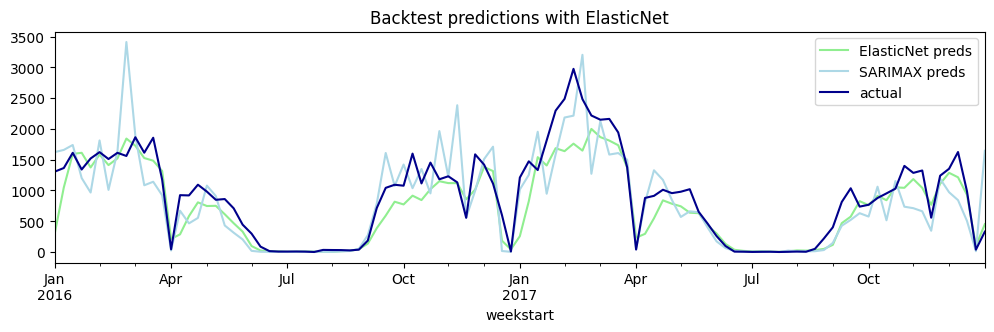

In [50]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3))
preds.rename(columns={'pred':'ElasticNet preds'}).plot(ax=ax, color='lightgreen')
preds3.rename(columns={'pred':'SARIMAX preds'}).plot(ax=ax, color='lightblue')
df.loc[end_train:end_validation]['cases'].plot(ax=ax, label='actual', color='darkblue')
ax.set_title('Backtest predictions with ElasticNet')
ax.legend()

In [52]:
print(f"ElasticNet mean absolute error  : {round(mean_absolute_error(df.loc[end_train:end_validation]['cases'],preds))}")
print(f"SARIMAX mean absolute error     : {round(mean_absolute_error(df.loc[end_train:end_validation]['cases'],preds3))}")

ElasticNet mean absolute error  : 216
SARIMAX mean absolute error     : 291


In [54]:
forecaster4 = ForecasterAutoreg(
    regressor=RandomForestRegressor(
        random_state=123,
        n_estimators=400,
        max_depth=10
    ),
    lags = [1,2,52],
    transformer_y=FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate=True),
    transformer_exog=StandardScaler(),
)

forecaster4.fit(y=df_train['cases'],exog=df_train.drop(columns=['cases']))

met4, preds4 = backtesting_forecaster(
    forecaster=forecaster4,
    y=df['cases'][:end_validation],
    exog=df.drop(columns=['cases'])[:end_validation],
    initial_train_size=len(df_train),
    steps = 2,
    metric='mean_absolute_error',
    refit=False,
    verbose=False,
    show_progress=True
)

c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
100%|██████████| 53/53 [00:01<00:00, 26.

In [56]:
forecaster4.get_feature_importances().set_index('feature').apply(abs).sort_values(by='importance',ascending=False)

,importance
feature,
lag_52,0.809820
lag_1,0.042942
epiweek_cos,0.013464
epiweek,0.007401
lag_2,0.006723
...,...
Days Unhealthy,0.000067
Main Pollutant_CO_L1,0.000003
Main Pollutant_CO,0.000002


In [57]:
X_train, y_train = forecaster4.create_train_X_y(
                    y    = df_train['cases'],
                    exog = df_train.drop(columns=['cases'])
                )

rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
y_train_sample = y_train.loc[sample]

regressor = RandomForestRegressor(random_state=123)

selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 15,
    n_jobs                 = -1
)
selector.fit(X_train_sample, y_train_sample)
selected_features_rfe = selector.get_feature_names_out()

print("Recursive feature elimination")
print("-----------------------------")
print(f"Total number of features available: {X_train.shape[1]}") 
print(f"Total number of records available: {X_train.shape[0]}")
print(f"Total number of records used for feature selection: {X_train_sample.shape[0]}")
print(f"Number of features selected: {len(selected_features_rfe)}")
print(f"Selected features : \n {selected_features_rfe}")

c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


Recursive feature elimination
-----------------------------
Total number of features available: 92
Total number of records available: 520
Total number of records used for feature selection: 260
Number of features selected: 62
Selected features : 
 ['lag_1' 'lag_2' 'lag_52' 'epiweek' 'GS_cold' 'GS_cough' 'GS_flu' 'AWND'
 'PRCP' 'TAVG' 'TMAX' 'TMIN' 'Overall AQI Value' 'CO' 'Ozone' 'PM10'
 'PM25' 'Days Good' 'Days Moderate' 'visits' 'epiweek_sin' 'epiweek_cos'
 'GS_cold_L1' 'GS_cold_L2' 'GS_cold_L3' 'GS_cough_L2' 'GS_fever_L2'
 'GS_fever_L3' 'GS_flu_L1' 'GS_flu_L2' 'GS_flu_L3' 'AWND_L1' 'AWND_L2'
 'AWND_L3' 'TAVG_L1' 'TAVG_L2' 'TAVG_L3' 'TMAX_L1' 'TMAX_L3' 'TMIN_L1'
 'TMIN_L2' 'TMIN_L3' 'Overall AQI Value_L1' 'Overall AQI Value_L2'
 'Overall AQI Value_L3' 'CO_L1' 'CO_L2' 'CO_L3' 'Ozone_L1' 'Ozone_L2'
 'Ozone_L3' 'PM10_L1' 'PM10_L2' 'PM10_L3' 'PM25_L1' 'PM25_L2' 'PM25_L3'
 'Days Moderate_L1' 'Days Moderate_L3' 'visits_L1' 'visits_L2' 'visits_L3']


In [58]:
selected_exog_features = [
    feature
    for feature in selected_features_rfe
    if not feature.startswith("lag_")
]

In [59]:
forecaster5 = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123,
        n_estimators=400,
        max_depth=10),
    lags=[1,2,52],
    transformer_y=FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate=True),
    transformer_exog=StandardScaler(),
)

forecaster5.fit(y=df_train['cases'],exog=df_train[selected_exog_features])

met5, preds5 = backtesting_forecaster(
    forecaster=forecaster5,
    y=df['cases'][:end_validation],
    exog=df[selected_exog_features][:end_validation],
    initial_train_size=len(df_train),
    steps = 2,
    metric='mean_absolute_error',
    refit=False,
    verbose=False,
    show_progress=True
)

c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
c:\Users\ljens\scoop\apps\python\current\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
100%|██████████| 53/53 [00:01<00:00, 28.

In [60]:
met5

164.0108085168352

In [61]:
forecaster5.get_feature_importances().set_index('feature').apply(abs).sort_values(by='importance',ascending=False)

,importance
feature,
lag_52,0.810348
lag_1,0.043400
epiweek_cos,0.013582
epiweek,0.007529
Overall AQI Value_L2,0.006982
...,...
Ozone_L2,0.000974
Days Moderate_L3,0.000926
PRCP,0.000860


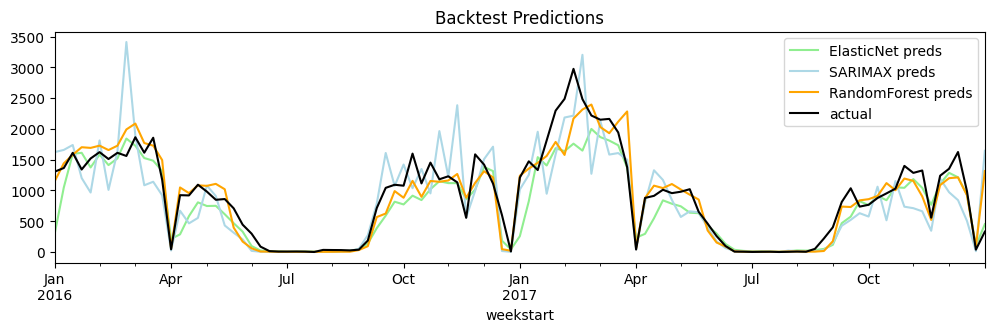

In [62]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3))
preds.rename(columns={'pred':'ElasticNet preds'}).plot(ax=ax, color='lightgreen')
preds3.rename(columns={'pred':'SARIMAX preds'}).plot(ax=ax, color='lightblue')
preds5.rename(columns={'pred':'RandomForest preds'}).plot(ax=ax,color='orange')
df.loc[end_train:end_validation]['cases'].plot(ax=ax, label='actual', color='black')
ax.set_title('Backtest Predictions')
ax.legend()

In [63]:
print(f"ElasticNet mean absolute error      : {round(mean_absolute_error(df.loc[end_train:end_validation]['cases'],preds))}")
print(f"SARIMAX mean absolute error         : {round(mean_absolute_error(df.loc[end_train:end_validation]['cases'],preds3))}")
print(f"RandomForest mean absolute error    : {round(mean_absolute_error(df.loc[end_train:end_validation]['cases'],preds5))}")

ElasticNet mean absolute error      : 216
SARIMAX mean absolute error         : 291
RandomForest mean absolute error    : 164


In [ ]:
baselineforecaster = ForecasterEquivalentDate(
    offset=52,
    n_offsets=2,
    agg_func=np.mean
)

baselineforecaster.fit(df_train['cases'])
baselineforecaster

In [ ]:
mb1, baseline_preds1 = backtesting_forecaster(
    forecaster=baselineforecaster,
    y=df['cases'],
    initial_train_size=len(df_train),
    refit=True,
    steps=1,
    verbose=False,
    metric='mean_absolute_error',
)



In [64]:
from skforecast.utils import save_forecaster, load_forecaster

In [66]:
save_forecaster(forecaster1, file_name='ElasticNet_001 hide.py',verbose=False)
save_forecaster(forecaster3, file_name='SARIMAX_001 hide.py',verbose=False)
save_forecaster(forecaster5, file_name='RandomForest_001 hide.py',verbose=False)
save_forecaster(baselineforecaster, file_name='baseline_001 hide.py',verbose=False)

ForecasterAutoreg 
Regressor: ElasticNetCV(l1_ratio=0.1, random_state=123, selection='random', verbose=False) 
Lags: [ 1 52] 
Transformer for y: FunctionTransformer(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                    validate=True) 
Transformer for exog: StandardScaler() 
Window size: 52 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['epiweek', 'GS_cold', 'GS_cough', 'GS_fever', 'GS_flu', 'AWND', 'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'Overall AQI Value', 'CO', 'Ozone', 'PM10', 'PM25', 'Days Good', 'Days Moderate', 'Days Unhealthy', 'visits', 'Main Pollutant_CO', 'Main Pollutant_NO2', 'Main Pollutant_Ozone', 'Main Pollutant_PM2.5', 'epiweek_sin', 'epiweek_cos', 'GS_cold_L1', 'GS_cold_L2', 'GS_cold_L3', 'GS_cough_L1', 'GS_cough_L2', 'GS_cough_L3', 'GS_fever_L1', 'GS_fever_L2', 'GS_fever_L3', 'GS_flu_L1', 'GS_flu_L2', 'GS_flu_L3', '